In [89]:
import numpy as np
import io
import re
from matplotlib import pyplot as plt
from math import ceil
from random import shuffle
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 4.0) # set default size of plots

In [3]:
root = "../data/"
train_dir = root + "stage1_train/"
image_id = "00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552"
train_label_path = root + "stage1_train_labels.csv"
save_path = "/Users/user/Desktop/git/ronjian.github.io/assets/2018_Data_Science_Bowl_Notes/"

In [95]:
object_list=[]
with io.open(train_label_path ,'r') as f:
    for line in f:
        if re.search(image_id , line) is not None:
            object_list.append(re.sub(image_id+",", "", line.strip("\n")))

In [40]:
# transform the run-length object data into 3D matrix pixels
def runlength_to_3D(obj_runlength, H, W):
    obj_1D = np.zeros((H*W*4,)) # this should be parameterized for different size image 
    obj_runlength_list = obj_runlength.split(" ")
    for i in range(len(obj_runlength_list)):
        if i % 2 == 0:
            start_point = int(obj_runlength_list[i])
        else:
            run_length = int(obj_runlength_list[i])
            obj_1D[start_point: start_point + run_length] = 255 # WHITE
    obj_3D = np.stack((obj_1D[0:0+H*W ].reshape(H,W).T,
                          obj_1D[1:1+H*W ].reshape(H,W).T,
                          obj_1D[2:2+H*W ].reshape(H,W).T,
                          obj_1D[3:3+H*W ].reshape(H,W).T
                          ), axis = -1)
    return obj_3D

In [41]:
sample_3D = runlength_to_3D(object_list[0], H=256, W=256)

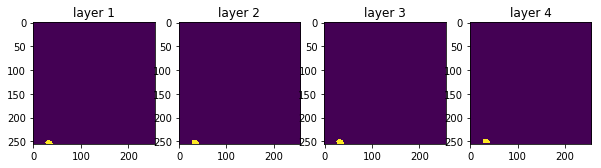

In [42]:
# each layer display, from left to right is 1st to 4th layer
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(sample_3D[:,:,i])
    plt.title("layer %s" % str(i+1))
plt.show()

$IoU(A,B) = \frac{A \cap B}{ A \cup B}$

In [76]:
# IoU between two matrix, if IoU =0 means no intersection.
def iou(gt, pred):
    gt_mask = gt>0
    pred_mask = pred>0
    intersection_cnt = np.sum(gt_mask * pred_mask)
    union_cnt = np.sum(gt_mask) + np.sum(pred_mask) - intersection_cnt
    iou = float(intersection_cnt) / float(union_cnt)
    return iou

$\frac{1}{|thresholds|} \sum_t \frac{TP(t)}{TP(t) + FP(t) + FN(t)}$  

In [96]:
# create fake predicting data, shrink the run-length by 25%
pred_object_list = []
for x in  object_list:
    obj_l = x.split(" ")
    tmp_str = ""
    for i in range(len(obj_l)):
        if i % 2 == 0 :
            start_point = obj_l[i]
        else:
            run_length = str(ceil( float(obj_l[i]) * 0.75 )) 
            if i == 1: 
                tmp_str += start_point + " " + run_length
            else:
                tmp_str += " " + start_point + " " + run_length
    pred_object_list.append(tmp_str)
shuffle(pred_object_list)

In [118]:
threshold_list = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
def image_precision(pred_object_list, object_list):
    tp_list = [0 for i in range(len(threshold_list))]
    for pred in pred_object_list:
        for gt in object_list:
            v_iou =  iou(runlength_to_3D(gt, H=256, W=256), runlength_to_3D(pred, H=256, W=256)) 
            if v_iou > threshold_list[0]:
                for i in range(len(threshold_list)):
                    if v_iou > threshold_list[i]:
                        tp_list[i] += 1
    ground_truth_len = len(object_list)
    pred_len = len(pred_object_list)
    precision_ttl = 0
    for i in range(len(tp_list)):
        tmp = float(tp_list[i]) / (ground_truth_len + pred_len - tp_list[i])
        print("precision is %f at threshold %f" % (tmp, threshold_list[i]))
        precision_ttl += tmp
    return precision_ttl / len(tp_list)

In [119]:
image_precision(pred_object_list, object_list)

precision is 1.000000 at threshold 0.500000
precision is 1.000000 at threshold 0.550000
precision is 1.000000 at threshold 0.600000
precision is 1.000000 at threshold 0.650000
precision is 1.000000 at threshold 0.700000
precision is 1.000000 at threshold 0.750000
precision is 0.102041 at threshold 0.800000
precision is 0.080000 at threshold 0.850000
precision is 0.000000 at threshold 0.900000
precision is 0.000000 at threshold 0.950000


0.6182040816326531